In [2]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 53.5 MB/s eta 0:00:00a 0:00:01


### Download PDB Structure

- From the list of IDs, download the structure -> contact map, and then extract sequence
- Don't use chain, just use real sequence? (unsure)

In [3]:
pdb_ids = ['2GWGA', '3LAEA', '4MC3A', '1TX4A', '3NHEA']

In [10]:
import requests
from Bio.PDB import PDBParser, PDBIO

# Define the PDB ID and chain
pdb_id = "1TX4"
chain_id = "A"
url = f"https://files.rcsb.org/download/{pdb_id}.pdb"

# Download the full PDB file
response = requests.get(url)
if response.status_code == 200:
    with open(f"{pdb_id}.pdb", "wb") as file:
        file.write(response.content)
    print(f"Downloaded full PDB file for {pdb_id}.")
else:
    print(f"Failed to download PDB file for {pdb_id}. Status code: {response.status_code}")

# Parse and save only the specified chain
parser = PDBParser()
structure = parser.get_structure(pdb_id, f"{pdb_id}.pdb")
io = PDBIO()
io.set_structure(structure[0][chain_id])  # structure[0] is the first model
io.save(f"{pdb_id}_{chain_id}.pdb")
print(f"Saved chain {chain_id} of {pdb_id} as {pdb_id}_{chain_id}.pdb")


Downloaded full PDB file for 1TX4.
Saved chain A of 1TX4 as 1TX4_A.pdb


/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3504.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3777.
  warnings.warn(


### Get Sequence

In [5]:
from Bio.PDB import PDBParser
from Bio.Seq import Seq
from Bio import SeqIO

# Load the PDB file
pdb_file = "1TX4_A.pdb"
sequence = "SNAIQQSDGSMIIDGSANLRDLNKMFNWELDTEDARTFNGLILEHLEEIPDEGTICEIDGLLITILEVGDNMIKQAKVVKL"
print(len(sequence))
parser = PDBParser()
structure = parser.get_structure("1TX4_A", pdb_file)

# Define the three-letter to one-letter amino acid conversion dictionary
three_to_one = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
    'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
    'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
}

# Extract sequence
sequence = []
for model in structure:
    for chain in model:
        for residue in chain:
            # Only consider standard amino acids
            if residue.id[0] == " " and residue.resname in three_to_one:
                # Append the one-letter code
                sequence.append(three_to_one[residue.resname])

# Join the sequence list into a single string
one_letter_sequence = ''.join(sequence)

# Print the sequence
print("PDB Sequence: \t\t", one_letter_sequence)
print("My data sequence:\t", sequence)

81
PDB Sequence: 		 PLPNQQFGVSLQHLQEKNPEQEPIPIVLRETVAYLQAHALTTEGIFRRSANTQVVREVQQKYNMGLPVDFDQYNALHLPAVILKTFLRELPEPLLTFDLYPHVVGFLNIDESQRVPATLQVLQTLPEENYQVLRFLTAFLVQISAHSDQNKMTNTNLAVVFGPNLLWAKDAAITLKAINPINTFTKFLLDHQGELF
My data sequence:	 ['P', 'L', 'P', 'N', 'Q', 'Q', 'F', 'G', 'V', 'S', 'L', 'Q', 'H', 'L', 'Q', 'E', 'K', 'N', 'P', 'E', 'Q', 'E', 'P', 'I', 'P', 'I', 'V', 'L', 'R', 'E', 'T', 'V', 'A', 'Y', 'L', 'Q', 'A', 'H', 'A', 'L', 'T', 'T', 'E', 'G', 'I', 'F', 'R', 'R', 'S', 'A', 'N', 'T', 'Q', 'V', 'V', 'R', 'E', 'V', 'Q', 'Q', 'K', 'Y', 'N', 'M', 'G', 'L', 'P', 'V', 'D', 'F', 'D', 'Q', 'Y', 'N', 'A', 'L', 'H', 'L', 'P', 'A', 'V', 'I', 'L', 'K', 'T', 'F', 'L', 'R', 'E', 'L', 'P', 'E', 'P', 'L', 'L', 'T', 'F', 'D', 'L', 'Y', 'P', 'H', 'V', 'V', 'G', 'F', 'L', 'N', 'I', 'D', 'E', 'S', 'Q', 'R', 'V', 'P', 'A', 'T', 'L', 'Q', 'V', 'L', 'Q', 'T', 'L', 'P', 'E', 'E', 'N', 'Y', 'Q', 'V', 'L', 'R', 'F', 'L', 'T', 'A', 'F', 'L', 'V', 'Q', 'I', 'S', 'A', 'H', 'S', 'D', 'Q', 'N', 'K', 'M', 'T'

#### Calculate Contact Map

In [6]:
import numpy as np
from Bio import PDB

def calculate_contact_map_binary(pdb_file, cutoff=8.0):
    # Initialize parser
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    # Get alpha carbon atoms
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if "CA" in residue:
                    ca_atoms.append(residue["CA"])

    # Get sequence length
    sequence_length = len(ca_atoms)
    
    # Initialize contact map
    contact_map = np.zeros((sequence_length, sequence_length), dtype=int)
    
    # Calculate distances and populate contact map
    for i in range(sequence_length):
        for j in range(i + 1, sequence_length):
            distance = ca_atoms[i] - ca_atoms[j]
            if distance <= cutoff:
                contact_map[i, j] = 1
                contact_map[j, i] = 1  # Symmetric matrix

    return contact_map

def calculate_distance_map(pdb_file):
    # Initialize parser
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    # Get alpha carbon atoms
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if "CA" in residue:
                    ca_atoms.append(residue["CA"])

    # Get sequence length
    sequence_length = len(ca_atoms)
    
    # Initialize distance map
    distance_map = np.zeros((sequence_length, sequence_length), dtype=float)
    
    # Calculate distances and populate distance map
    for i in range(sequence_length):
        for j in range(i + 1, sequence_length):
            distance = ca_atoms[i] - ca_atoms[j]
            distance_map[i, j] = distance
            distance_map[j, i] = distance  # Symmetric matrix

    return distance_map

# Path to your uploaded PDB file
pdb_file_path = '1TX4_A.pdb'
contact_map = calculate_distance_map(pdb_file_path)

# Display the contact map array shape and a snippet of the map
print("Contact Map Shape:", contact_map.shape)
print(contact_map)


Contact Map Shape: (196, 196)
[[ 0.          3.78756499  6.60843277 ... 38.33052444 34.97867203
  33.24429703]
 [ 3.78756499  0.          3.81272006 ... 39.54745483 36.34516907
  34.27790833]
 [ 6.60843277  3.81272006  0.         ... 38.7641983  35.61566925
  33.26684189]
 ...
 [38.33052444 39.54745483 38.7641983  ...  0.          3.78982782
   5.83794737]
 [34.97867203 36.34516907 35.61566925 ...  3.78982782  0.
   3.83226585]
 [33.24429703 34.27790833 33.26684189 ...  5.83794737  3.83226585
   0.        ]]


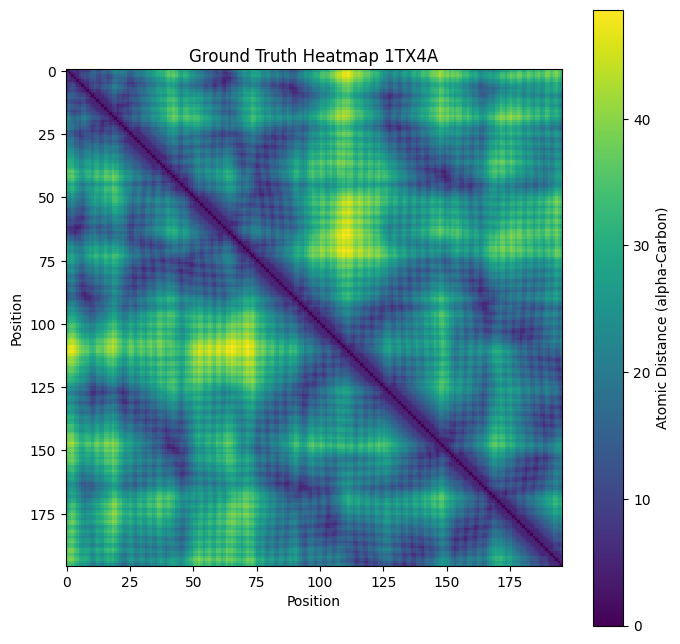

In [7]:
import matplotlib.pyplot as plt
# Plot contact map
# Make the heatmap plot
plt.figure(figsize=(8, 8))
plt.imshow(contact_map, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Atomic Distance (alpha-Carbon)")
plt.title("Ground Truth Heatmap 1TX4A")
plt.xlabel("Position")
plt.ylabel("Position")
plt.show()

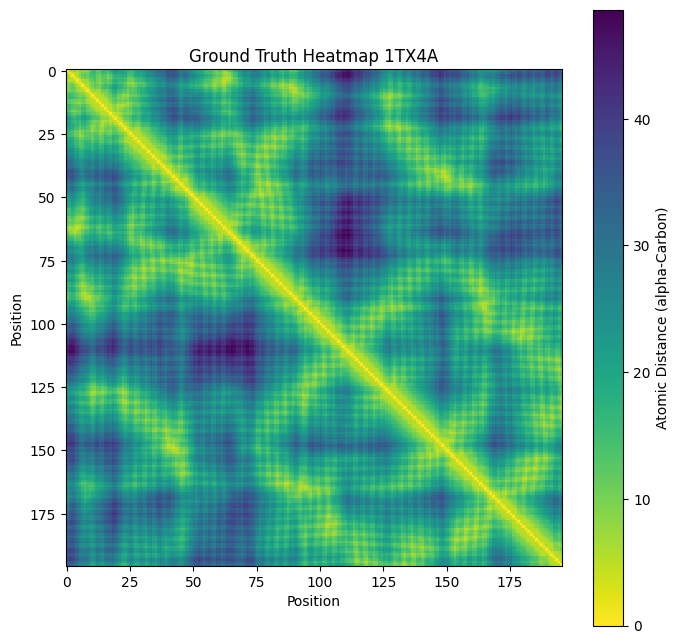

In [9]:
import matplotlib.pyplot as plt
# Plot contact map
# Make the heatmap plot
plt.figure(figsize=(8, 8))
plt.imshow(contact_map, cmap="viridis_r", interpolation="nearest")
plt.colorbar(label="Atomic Distance (alpha-Carbon)")
plt.title("Ground Truth Heatmap 1TX4A")
plt.xlabel("Position")
plt.ylabel("Position")
plt.show()

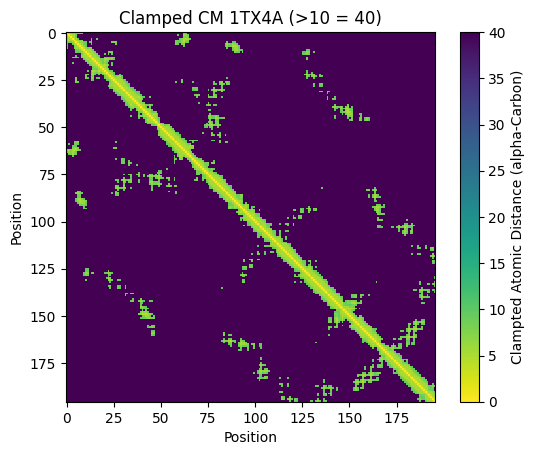

In [13]:
# Map values above 20 to 40
threshold_value = 10
new_value = 40
mapped_matrix = np.where(contact_map > threshold_value, new_value, contact_map)
# plt.figure(figsize=(8, 8))
plt.imshow(mapped_matrix, cmap="viridis_r", interpolation="nearest")
plt.colorbar(label="Clampted Atomic Distance (alpha-Carbon)")
plt.title("Clamped CM 1TX4A (>10 = 40)")
plt.xlabel("Position")
plt.ylabel("Position")
plt.show()